In [117]:
import pandas as pd
import geopandas as gpd
import bokeh
from bokeh.tile_providers import CARTODBPOSITRON
from bokeh.plotting import figure, show
from shapely.geometry import Point
from dateutil.parser import parse
import matplotlib.pyplot as plt
import requests
from requests.exceptions import Timeout
import json
from collections import defaultdict


# Read in csv (downloaded from Cambridge's Open Data Portal)
df = pd.read_csv('seeclickfix.csv')

In [118]:
# Get a list of all icy or unshoveled sidewalks created since 12/01/19
df.head()
snowy = df[df['issue_type'] == 'Icy or Unshoveled Sidewalk']

# Turn into a geopandas dataframe
geometry = [Point(xy) for xy in zip(snowy.lng, df.lat)]
crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(snowy, crs=crs, geometry=geometry)

# Turn the created and closed dates into datetime objects
gdf = gdf.assign(ticket_created_date_time=gdf['ticket_created_date_time'].map(lambda x: parse(x)))
#gdf['ticket_closed_date_time'] = gdf['ticket_closed_date_time'].map(lambda x: parse(x))

gdf = gdf[gdf['ticket_created_date_time'] > parse('12/1/2017')]
gdf.head()

still_open = gdf[gdf['ticket_closed_date_time'].isna()]
closed = gdf[gdf['ticket_closed_date_time'].notna()]

print(still_open.shape)
print(closed.shape)
#still_open.sha
gdf.shape


closed = closed.assign(ticket_closed_date_time=closed['ticket_closed_date_time'].map(lambda x: parse(x)))
closed = closed.assign(days_open= closed['ticket_closed_date_time'] - closed['ticket_created_date_time'])

#df.assign(temp_f=df['temp_c'] * 9 / 5 + 32)
closed['days_open'] = closed['days_open'].apply(lambda x: pd.Timedelta.round(x, 'd').days)
closed.head()

#pd.Timedelta.round(closed.iloc[0]['days_open'], 'd')
len(closed)

(2, 14)
(2048, 14)


2048

In [119]:
# Read cached comment data
with open('see_click_fix_comments.json') as json_file:
    comments = json.load(json_file)

# Remove all tickets with duplicate in the comments
dupes = []
comments[[x for x in comments.keys()][0]]
for ticket_id, value in comments.items():
    for item in value:
        if 'duplicate' in item['comment']:
            dupes.append(ticket_id)
closed = closed[-closed['ticket_id'].isin(dupes)]
len(closed)

1936

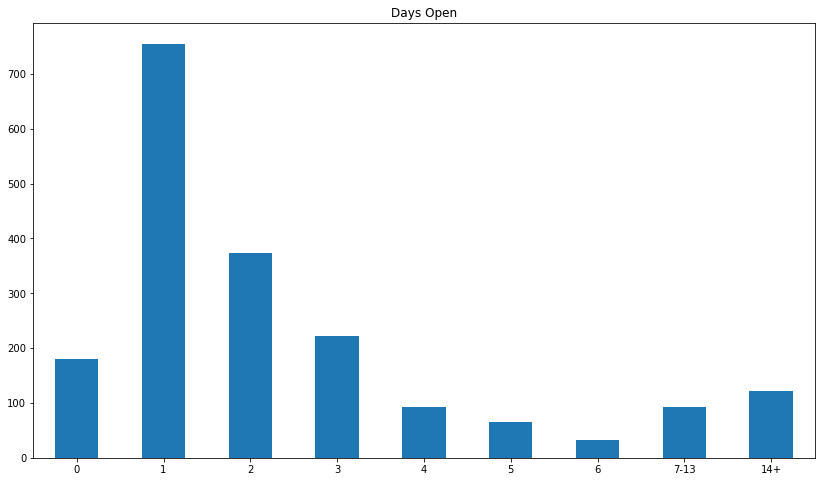

In [129]:
# Bin longer tickets'
closed.loc[closed.days_open >= 14, 'days_open'] = 14
closed.loc[closed.days_open.isin(range(7, 14)), 'days_open'] = 7

days_counts = closed['days_open'].value_counts().sort_index()

# Relabel
days_counts = days_counts.rename({14: '14+', 7: '7-13'})

ax = days_counts.plot(kind='bar', rot=0,
                                    figsize=(14,8),
                                    title="Days Open")

In [ ]:
def get_resolution(ticket_id, closed_time):

    for comment in comments[str(ticket_id)]:
        dt = parse(comment['created_at'])
        # Look for comments matching ticket closed time
        if dt.strftime("%m/%d/%Y, %H:%M:%S") == closed_time.strftime("%m/%d/%Y, %H:%M:%S"):
            if 'citation was issued' in comment['comment'] \
              or 'notice was issued' in comment['comment']:
                return 'citation'
            elif 'pleased' in comment['comment'] and 'resolved' in comment['comment']:
                return 'resolved'
            elif 'new snow operation' in comment['comment'] \
              or 'suspended during this snow event' in comment['comment'] \
              or 'anticipated snowfall' in comment['comment'] \
              or 'anticipation of another snow storm' in comment['comment']:
                return 'new_snow'
            # These should probably be filtered out of the total
            elif 'we are still in an snow operation' in comment['comment'] \
              or '12 hours' in comment['comment'] \
              or 'City Ordinance' in comment['comment']:
                return 'still_snowing'
            elif 'large number of reports' in comment['comment'] and 'now in compliance' in comment['comment']:
                return 'delayed_inspection'
            elif 'we were unable to inspect this location' in comment['comment'] \
              or 'location has not been inspected' in comment['comment'] \
              or ('warm' in comment['comment'] and 'weather' in comment['comment']) \
              or ('warm' in comment['comment'] and 'temperature' in comment['comment']):
                return 'no_inspection'
            elif 'found to be in compliance' in comment['comment']:
                return 'in_compliance'
            elif 'state property' in comment['comment']:
                return 'state_property'
            elif 'duplicat' in comment['comment']:
                return 'duplicate'
            elif 'Somerville' in comment['comment']:
                return 'somerville'
            elif 'MBTA' in comment['comment']:
                return 'mbta'
            elif 'city of cambridge will' in comment['comment'].lower() \
              or 'city will' in comment['comment'].lower() \
              or 'will try and clear as soon as possible' in comment['comment'] \
              or 'city pile' in comment['comment'].lower():
                return 'city_will_address'
            else:
                #print(str(ticket_id) + "," + comment['comment'])
                return 'other'
        print(comments[str(ticket_id)])    

resolutions = defaultdict(int)
closed = closed.assign(resolution=None)
other_comments = []
for index, row in closed.iterrows():
    resolution = get_resolution(row['ticket_id'], row['ticket_closed_date_time'])
    resolutions[resolution] += 1
    closed.at[index,'resolution'] = resolution
    if resolution == 'other':
        other_comments.append(comments[str(row['ticket_id'])])

print(resolutions)
closed.head()

In [ ]:
# Print some comments for the unassigned versions
other_resolution = closed[closed['resolution'] == 'other']
other_resolution.head()

In [ ]:
# To do: filter on role: "Verified Official"

In [ ]:
p = figure(x_range=(-7919969.67, -7911590.87), y_range=(5221575.24, 5214113.74), x_axis_type="mercator", y_axis_type="mercator")
p.add_tile(CARTODBPOSITRON)
show(p)

#coords = [[-9759284.802320646, -9759781.18], [5139718.458609748, 5162158.11]]    
#p.line(x=coords[0], y=coords[1])